<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
 
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduce_image(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


# Histogram equalization
# https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def histEqualization(dataset):
  equ_dataset = dataset # copy input dataset
  for n in range(len(dataset)):
    # convert to YUV
    img_yuv = cv2.cvtColor(dataset[n]['image'], cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    equ_dataset[n]['image']  = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return equ_dataset


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("/n")

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [4]:
#Retrieve original images
data_path = "drive/My Drive/ECE_542-Project_1/TrainingData"
# images, annotations = get_data(path)
img_names, images = loadImages(data_path)

# Get annotation csv file
# annotations = pd.read_csv(data_path)
annotations_path = os.path.join(data_path, 'Annotations.csv')
f_names, labels = loadAnnotations(annotations_path)

# Build dictionary with data
dataset = buildDataset(f_names, labels, img_names, images)
print("Initial count")
countClasses(dataset)

# Preprocess images using histogram equalization
dataset = histEqualization(dataset)


Initial count
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275


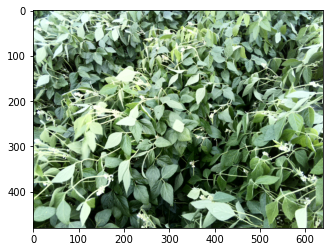

In [5]:
#Display an image from dataset
sampleID = 19
plt.imshow(dataset[sampleID]['image'])
# print(dataset[sampleID])

In [6]:
# Labels
# labels = np.asarray(annotations[['annotation']]).ravel() # Labels

# Spliting in images and pre_test
# split = int(0.8 * len(images))
# pre_test = images[split:]
# images = images[:split]
# pre_test_labels = labels[split:]
# labels = labels[:split]
print("Before Split")
countClasses(dataset)

# Extract the same number of samples for the test dataset
n_samples = 20;
test_dataset = [] # start with empty set
for a in range(5):
  cnt = 0
  for i in dataset:
    if i['annotation']==a and cnt<n_samples:
      test_dataset.append(i)
      cnt += 1
# Update dataset
dataset = [i for i in dataset if i not in test_dataset]

print("After Split")
countClasses(dataset)


Before Split
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275
After Split
Class 0: 468
Class 1: 309
Class 2: 110
Class 3: 111
Class 4: 177
 Total : 1175


In [7]:
# Data Augmentation Schemes
 
# Flipping image
def flip_image(images, labels, size = 480, flips = 3):
  images = reduce_image(images, size)
  flip_h = np.flip(images, axis = 1)
  flip_v = np.flip(images, axis = 2)
  flip_hv = np.flip(np.flip(images, axis = 1), axis = 2)
  if flips == 1:
     flip = np.vstack([images, flip_h])
     labels = np.asarray(list(labels) * 2).ravel()
  if flips == 2:
    flip = np.vstack([images, flip_h, flip_v])
    labels = np.asarray(list(labels) * 3).ravel()
  if flips == 3:
    flip = np.vstack([images, flip_h, flip_v, flip_hv])
    labels = np.asarray(list(labels) * 4).ravel()
  return flip, labels

# Gamma correction
def gamma_image(images, labels, gamma_values):
  images_gamma = [images]
  for gamma in gamma_values:
    #gamma_M = (np.power(images/255.0, 1/gamma) * 255).astype(int)
    images_gamma.append((np.power(images/255.0, 1/gamma) * 255).astype(int))#[labels == where_labels])
  images_gamma = np.vstack(images_gamma)
  #images_gamma = np.asarray(images_gamma)
  labels = np.asarray(list(labels) * (len(gamma_values) + 1)).ravel()
  return images_gamma, labels

# Divide image (NO IMPROVEMENT)
def slice_image(images, labels, num_slices):
  images_slice = []
  num_slices = 5
  sx = (np.arange(0, num_slices + 1) / num_slices * images.shape[1]).astype(int)
  sy = (np.arange(0, num_slices + 1) / num_slices * images.shape[2]).astype(int)
  for j in range(num_slices):
    for i in range(num_slices):
      images_slice.append(images[:, sx[i]:sx[i + 1], sy[j]:sy[j + 1], :])
  images_slice = np.vstack(images_slice)
  labels = np.asarray(list(labels) * num_slices * num_slices).ravel()
  return images_slice, labels



In [8]:
# Data augmentation
# Flipping image
# def flip_image(images, labels):
#   idx = np.asarray([2, 3, 4])
#   n = 0
#   row_idx = []
#   for label in labels:
#     if any(i == label for i in idx):
#       row_idx.append(n)
#       n +=1
#     else:
#       n +=1 

#   row_idx = np.asarray(row_idx)
#   flip_h = np.flip(images[row_idx], axis = 1)
#   flip = np.vstack([images, flip_h])
#   hold = labels[row_idx]
#   labels = np.hstack([labels, hold])
#   return flip, labels

# images, labels = flip_image(images, labels)
# print(images.shape)
# print(labels.shape)
# print("Class 0:", np.sum(labels == 0))
# print("Class 1:", np.sum(labels == 1))
# print("Class 2:", np.sum(labels == 2))
# print("Class 3:", np.sum(labels == 3))
# print("Class 4:", np.sum(labels == 4))

In [9]:
# Randomnize dataset
np.random.shuffle(dataset) # shuffle dataset
# extract images and labels from dataset
images = [ d['image'] for d in dataset ]
labels = [ d['annotation'] for d in dataset ]

# convert to np arrays
images = np.asarray(images)
labels = np.asarray(labels)

In [10]:
# Reducing Images
size = 224
resized_images = reduce_image(images, size)
# resized_images = images # no resizing for now
# resized_images = images
# print(resized_images.shape)
# print(pre_test.shape)

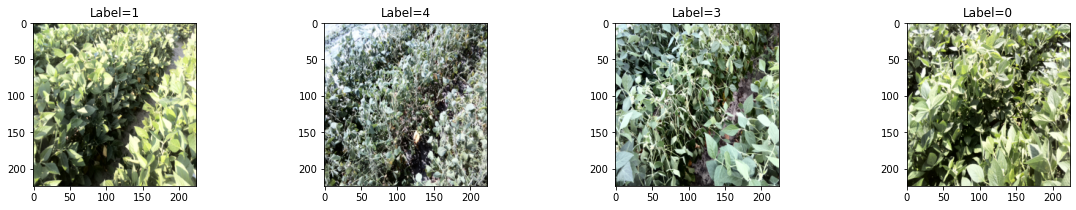

In [11]:
# Plotting 16 random images
Num = 4
N = np.random.randint(0,len(resized_images), Num) 
# Plot
fig, axes = plt.subplots(1, Num, figsize=(20,3))
ax = axes.ravel()
for i in range(Num):
  ax[i].imshow(resized_images[N[i]])
  title = "Label=" + str(labels[N[i]])
  ax[i].title.set_text(title)

In [12]:
#Keeping 40% for Validation
valid_set_pc = 0.4
split= int((len(resized_images))*(1-valid_set_pc))

#labels = annotations[['annotation']]
validX = resized_images[split:]
validY = labels[split:]
 
trainX = resized_images[:split]
trainY = labels[:split]

#Convert from integers to floats
resized_images = resized_images.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
 
# Normalize to range 0-1
resized_images = resized_images / 255.0
trainX = trainX / 255.0
validX = validX / 255.0
 
print(np.unique(labels), np.unique(trainY), np.unique(validY))
 
# One-hot encoding of outputs
labels = to_categorical(labels)
trainY = to_categorical(trainY)
validY = to_categorical(validY)
 
print(resized_images.shape)

[0 1 2 3 4] [0 1 2 3 4] [0 1 2 3 4]
(1175, 224, 224, 3)


In [13]:
# Defining Base CNN Model
def define_base_model(height, width, rate):
    model = Sequential()
 
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
    model.add(Dropout(rate))
    model.add(MaxPooling2D((2, 2)))
 
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(Dropout(rate))
    model.add(MaxPooling2D((2, 2)))
 
    #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
    #model.add(Dropout(rate))
    #model.add(MaxPooling2D((2, 2)))
 
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate))    
    model.add(Dense(5, activation='softmax'))
 
    return model


In [19]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(224, 224, 3), include_top=False)

# Freeze model
vgg.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(5, activation='softmax')(x) # 5 classes

# Creating instance
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])


# summarize the model
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
# Train the model
history = model.fit(trainX, trainY, epochs=35, validation_data=(validX, validY), verbose=1)

Epoch 1/35
23/23 [==============================] - 6s 257ms/step - loss: 1.5950 - categorical_accuracy: 0.4865 - val_loss: 0.9970 - val_categorical_accuracy: 0.5957
Epoch 2/35
23/23 [==============================] - 4s 190ms/step - loss: 0.7921 - categorical_accuracy: 0.6837 - val_loss: 0.7146 - val_categorical_accuracy: 0.7043
Epoch 3/35
23/23 [==============================] - 4s 191ms/step - loss: 0.4535 - categorical_accuracy: 0.8511 - val_loss: 0.8728 - val_categorical_accuracy: 0.6468
Epoch 4/35
23/23 [==============================] - 4s 192ms/step - loss: 0.4136 - categorical_accuracy: 0.8482 - val_loss: 0.6955 - val_categorical_accuracy: 0.7298
Epoch 5/35
23/23 [==============================] - 4s 193ms/step - loss: 0.2909 - categorical_accuracy: 0.9305 - val_loss: 0.6921 - val_categorical_accuracy: 0.7170
Epoch 6/35
23/23 [==============================] - 4s 195ms/step - loss: 0.2562 - categorical_accuracy: 0.9291 - val_loss: 0.6431 - val_categorical_accuracy: 0.7255
Epoc

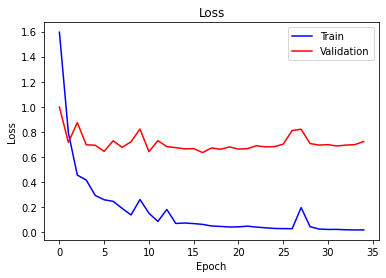

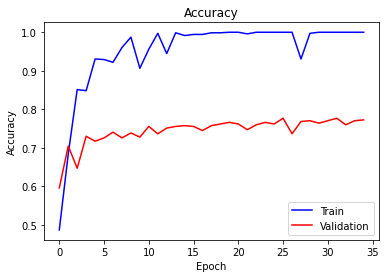

In [21]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

In [25]:
# F1 Score
trueY = np.argmax(validY, axis=1)

# base_results = model.predict_classes(validX) # 'Functional' object has no attribute 'predict_classes'
base_results = model.predict(validX)
base_results = np.argmax(base_results,axis=1)

base_f1_score = f1_score(trueY, base_results, average=None)
print(base_f1_score)

[0.90249433 0.62780269 0.69230769 0.74626866 0.64122137]


In [26]:
# Test set

# extract images and labels from dataset
pre_test_images = [ d['image'] for d in test_dataset ]
pre_test_labels = [ d['annotation'] for d in test_dataset ]

# Measure performance on test set
pre_test_images = reduce_image(pre_test_images, 224)
pre_test_results = model.predict(pre_test_images)
pre_test_results = np.argmax(pre_test_results,axis=1)

print(np.sum(pre_test_results == pre_test_labels)/len(pre_test_labels))

0.24


In [27]:
# F1 Score Test set
trueY = test_labels
test_f1_score = f1_score(trueY, pre_test_results, average=None)
print(test_f1_score)

[0.37383178 0.         0.0952381  0.20689655 0.        ]


In [29]:
# Generate CSV
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))

print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

test_images = reduce_image(test, 224)
# print(test_images.shape)
test_results = model.predict(test_images)
test_results = np.argmax(test_results,axis=1)

print("Class 0:", np.sum(test_results == 0))
print("Class 1:", np.sum(test_results == 1))
print("Class 2:", np.sum(test_results == 2))
print("Class 3:", np.sum(test_results == 3))
print("Class 4:", np.sum(test_results == 4))

# Generate CSV file
data = {'file_name': file_name,'annotation': test_results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction1.csv', index = False, header=True)
print(export_data)

['020031.jpg', '020244.jpg', '020446.jpg', '020597.jpg', '020693.jpg', '020720.jpg', '020783.jpg', '020795.jpg', '020810.jpg', '020833.jpg', '020835.jpg', '020848.jpg', '020861.jpg', '020877.jpg', '020881.jpg', '020963.jpg', '020980.jpg', '021039.jpg', '021048.jpg', '021095.jpg', '021104.jpg', '021220.jpg', '021267.jpg', '021366.jpg', '021423.jpg', '021455.jpg', '021457.jpg', '021621.jpg', '021659.jpg', '021729.jpg', '021763.jpg', '021773.jpg', '021818.jpg', '021819.jpg', '022010.jpg', '022021.jpg', '022090.jpg', '022127.jpg', '022145.jpg', '022158.jpg', '022202.jpg', '022231.jpg', '022377.jpg', '022385.jpg', '022432.jpg', '022438.jpg', '022497.jpg', '022551.jpg', '022554.jpg', '022628.jpg', '022629.jpg', '022642.jpg', '022757.jpg', '022800.jpg', '022826.jpg', '023041.jpg', '023112.jpg', '023195.jpg', '023229.jpg', '023278.jpg', '023291.jpg', '023304.jpg', '023330.jpg', '023369.jpg', '023370.jpg', '023381.jpg', '023458.jpg', '023468.jpg', '023474.jpg', '023476.jpg', '023508.jpg', '0235